# Rolling Sum

**TL;DR** This notebook demonstrates the performance improvement of using a numba JIT compiled algorithm for calculating rolling sum over the Pandas equivalent for some sample data.

In [1]:
from numba import jit
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 16, 8

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from utilities.rolling_stats import rolling_sum  # this is the function we're going to test versus pandas

In [3]:
x = np.arange(30).astype(float)

In [4]:
s = pd.Series(x)
s[0] = np.nan
s[6] = np.nan
s[12:18] = np.nan
s[-1] = np.nan
s.values  # arbitrary but small input data

array([ nan,   1.,   2.,   3.,   4.,   5.,  nan,   7.,   8.,   9.,  10.,
        11.,  nan,  nan,  nan,  nan,  nan,  nan,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  nan])

In [5]:
s.rolling(window=3).sum().values  # pandas output

array([ nan,  nan,  nan,   6.,   9.,  12.,  nan,  nan,  nan,  24.,  27.,
        30.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  57.,  60.,
        63.,  66.,  69.,  72.,  75.,  78.,  81.,  84.,  nan])

In [6]:
rolling_sum(s.values, 3)  # rolling_sum output

array([ nan,  nan,  nan,   6.,   9.,  12.,  nan,  nan,  nan,  24.,  27.,
        30.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  57.,  60.,
        63.,  66.,  69.,  72.,  75.,  78.,  81.,  84.,  nan])

In [7]:
a = s.rolling(window=3).sum().values
b = rolling_sum(s.values, 3)
np.allclose(a, b, equal_nan=True)

True

In [8]:
def benchmarks():
    
    res = []
    
    for exponent in range(3, 7):
        n = 10**exponent
        data = np.arange(n).astype(float)
        data[3] = np.nan
        data[4] = np.nan
        data[-1] = np.nan
        s = pd.Series(data)
        
        window = int(max(1000, n * 0.1))  # cap window size at 1,000
        
        t1 = time.time()
        pandas_output = s.rolling(window=window).sum().values
        t2 = time.time()
        res.append(('pandas', n, (t2 - t1)))
    
        t1 = time.time()
        rsum_output = rolling_sum(s.values, window)
        t2 = time.time()
        res.append(('rolling_sum', n, (t2 - t1))) 
        
        assert np.allclose(pandas_output, rsum_output, equal_nan=True)
        
    return res

In [9]:
data = benchmarks()
df = pd.DataFrame(data, columns = ['fn', 'population', 'time (ms)'])

df['time (ms)'] = df['time (ms)'].apply(lambda x: x * 1000.) 
df = pd.pivot_table(df, values='time (ms)', index=['population'], columns=['fn'], aggfunc=np.sum)
df

fn,pandas,rolling_sum
population,,
1000,0.952959,0.019073
10000,2.532959,0.187874
100000,15.953779,1.137972
1000000,113.173962,11.007071


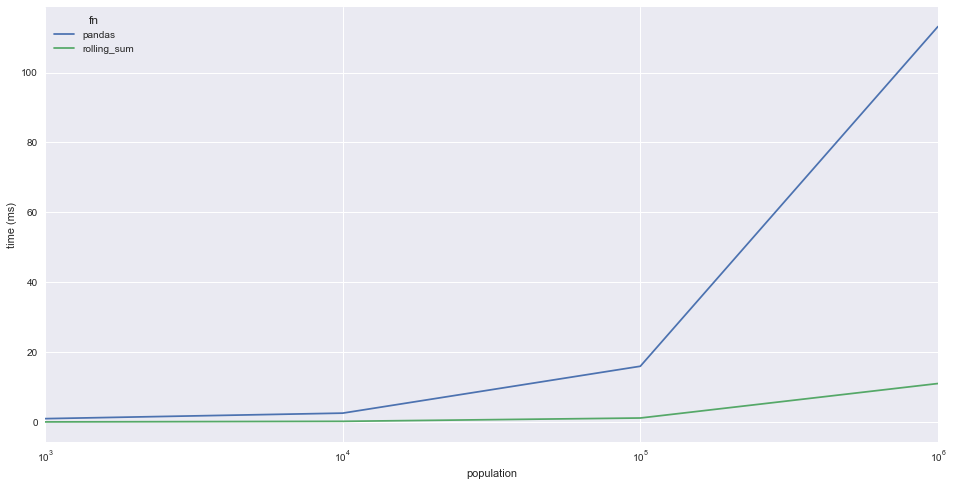

In [10]:
df.plot(logx=True)
plt.ylabel('time (ms)')